In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [6]:
## load csv files in folder
folder = os.path.abspath('./good_metrics/new_features')

files = [f for f in os.listdir(folder) if f.endswith('.csv')]

df_list = []
for f in files:
    splitted_filename = f.split('_')
    if '-' in splitted_filename[1]:
        model_name = splitted_filename[0]
    else:
        model_name = splitted_filename[0] + '_' + splitted_filename[1]

    temp_df = pd.read_csv(os.path.join(folder, f))
    temp_df['Model'] = model_name
    df_list.append(temp_df)
df = pd.concat(df_list, ignore_index=True)

for metric in df.columns:
    if '(ms)' in metric:
        base_metric = metric.replace(' (ms)', '')
        if base_metric in df.columns:
            # Only update non-NaN values from the (ms) column
            df[base_metric] = df[base_metric].combine_first(df[metric])
        else:
            # If base column doesn't exist, just rename it
            df.rename(columns={metric: base_metric}, inplace=True)

print(np.unique(df['Model']))
print(df.columns.tolist())

['CNN' 'GRU' 'GRU_Attention' 'GRU_Conv' 'LSN' 'LSTM' 'MLP' 'Parametric'
 'STGCN' 'STTR' 'STTR_Acute']
['Event', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1', 'MATE', 'median ATE', 'MATE_std', 'minmax ATE', 'MTE', 'median TE', 'MTE_std', 'minmax TE', 'Model', 'FN early (%)', 'FN middle (%)', 'FN late (%)', 'FN count', 'FP early (%)', 'FP middle (%)', 'FP late (%)', 'FP count']


In [7]:
## What to plot and how
metrics = ['Precision', 'Recall', 'F1']
ms_metrics = ['MATE', 'median ATE', 'MATE_std']
events = df['Event'].unique()
# model_order = ['STTR', 'STGCN', 'LSTM', 'LSN', 'GRU', 'GRU_Attention', 'GRU_Conv', 'CNN', 'MLP', 'Parametric']
model_order = ['STTR', 'STTR_Acute']#, 'Parametric']

Model
CNN              4
GRU              4
GRU_Attention    4
GRU_Conv         4
LSN              4
LSTM             4
MLP              4
Parametric       4
STGCN            4
STTR             4
STTR_Acute       5
dtype: int64
Precision     0
Recall        0
F1            0
MATE          0
median ATE    0
MATE_std      0
dtype: int64
       Precision    Recall        F1
count   2.000000  2.000000  2.000000
mean    0.007554  0.005335  0.005952
std     0.006882  0.003743  0.004616
min     0.002688  0.002688  0.002688
25%     0.005121  0.004012  0.004320
50%     0.007554  0.005335  0.005952
75%     0.009987  0.006659  0.007584
max     0.012420  0.007982  0.009216


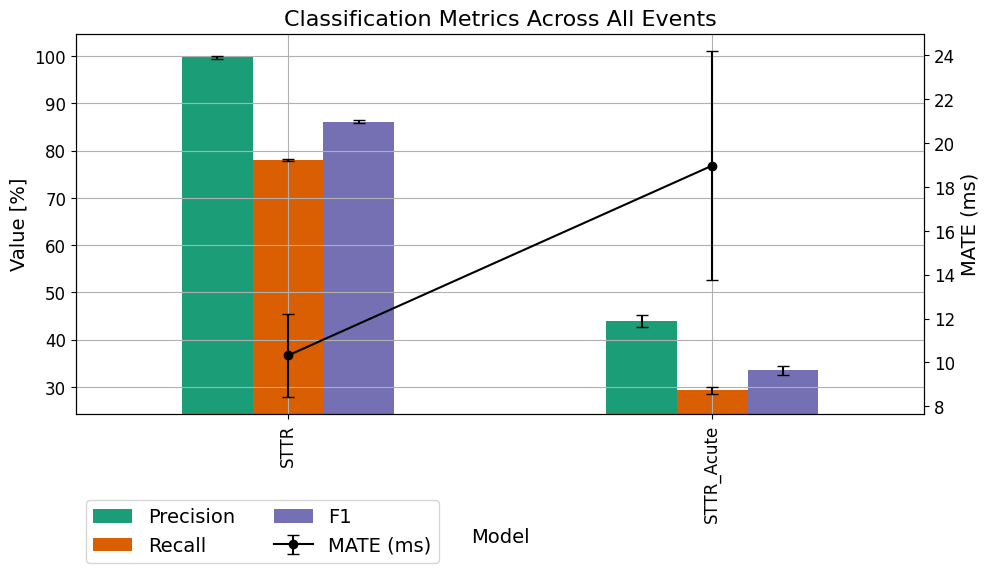

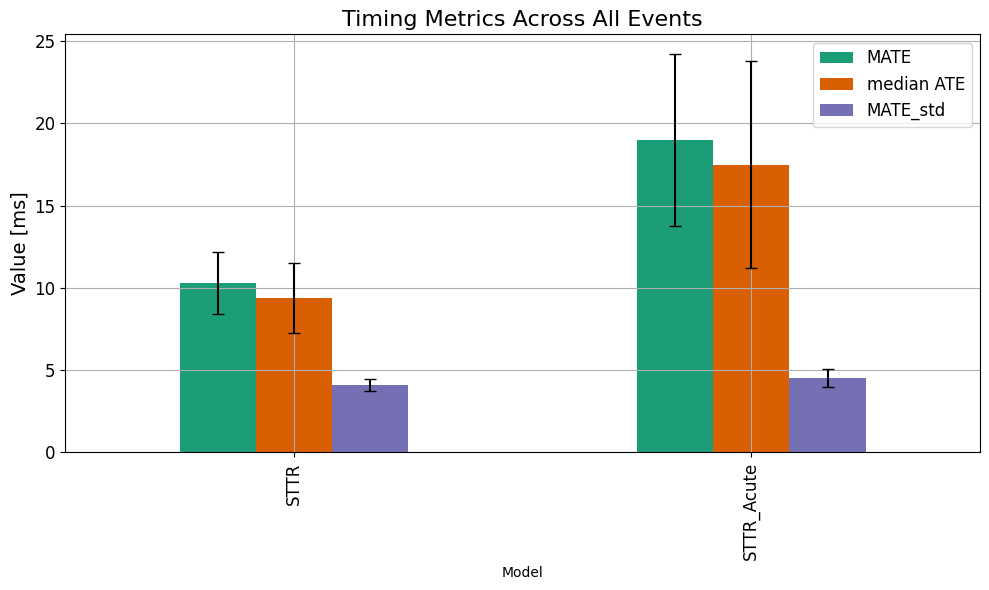

In [9]:
# Group and reorder
model_stats = df.groupby('Model')[metrics + ms_metrics]
model_means = model_stats.mean().reindex(model_order)
model_sem = model_stats.sem().reindex(model_order)

print(df.groupby('Model').size())           # Check group counts
print(model_sem.isna().sum())               # Check for SEM NaNs
print(model_sem[metrics].describe())

## Color map
cmap = plt.get_cmap('Dark2')
num_models = len(model_means) +  1
bar_colors = [cmap(i) for i in range(num_models)]

## Plotting metrics
fig, ax1 = plt.subplots(figsize=(10, 6))
model_means[metrics] = model_means[metrics] * 1e2 # Convert to percentage
model_sem[metrics] = model_sem[metrics] * 1e2 # Convert to percentage
model_means[metrics].plot(kind='bar', yerr=model_sem[metrics], capsize=4, ax=ax1, color=bar_colors)

# Add MATE (ms) as a line plot with SEM as error bars using a secondary y-axis
ax3 = ax1.twinx()
ax3.errorbar(
    model_means.index,
    model_means['MATE'],
    yerr=model_sem['MATE'],
    color='black',
    marker='o',
    label='MATE (ms)',
    linewidth=1.5,
    markersize=6,
    capsize=4
)
ax3.set_ylabel('MATE (ms)', fontsize=14, color='black')
ax3.tick_params(axis='y', labelsize=12, colors='black')
# ax3.set_ylim(0, max(model_means['MATE'] + model_sem['MATE']) * 1.1)

ax1.set_title('Classification Metrics Across All Events', fontsize=16)
ax1.set_ylabel('Value [%]', fontsize=14)
ax1.set_ylim(min(model_means[metrics].min()) - 0.05 * max(model_means[metrics].max()), max(model_means[metrics].max()) + 0.05 * max(model_means[metrics].max()))
ax1.set_xlabel('Model', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax3.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, -0.2), ncol=2, fontsize=14)
plt.tight_layout()
plt.show()

# Plotting timing metrics
fig, ax2 = plt.subplots(figsize=(10, 6))
model_means[ms_metrics].plot(kind='bar', yerr=model_sem[ms_metrics], capsize=4, ax=ax2, color=bar_colors)

ax2.set_title('Timing Metrics Across All Events', fontsize=16)
ax2.set_ylabel('Value [ms]', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)
plt.tight_layout()
plt.show()
